# AOLME Datasets Generator

This is a fast CSV dataset generator from transcripts of AOLME Sessions in MS Word format.

We start with the import declarations:

In [99]:
import sys
import docx
import json
import re
import unidecode
import os

from datetime import datetime
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from pandas import DataFrame

Next, the method used to process the MS Word files and load roles:

In [100]:
students = []
facilitators = []
co_facilitators = []
non_role = []

def load_roles():
    with open('roles.json') as json_file:
        data = json.load(json_file)

        for p in data['Student']:
            students.append(p)

        for p in data['Facilitator']:
            facilitators.append(p)

        for p in data['CoFacilitator']:
            co_facilitators.append(p)

        for p in data['NonRole']:
            non_role.append(p)

In [101]:
def process_line(line: str):
    role = ''
    index = line.find(':')

    if index != -1:
        first_part = line[0:index]
        second_part = line[index + 1:].lower().strip()

        for pattern in non_role:
            m = re.search(pattern, first_part)

            if m is not None:
                return None, None

        keep_searching = True

        for pattern in facilitators:
            m = re.search(pattern, first_part)

            if m is not None:
                role = 'Facilitator'
                keep_searching = False

        if keep_searching:
            for pattern in co_facilitators:
                m = re.search(pattern, first_part)

                if m is not None:
                    role = 'Co-Facilitator'
                    keep_searching = False

        if keep_searching:
            for pattern in students:
                m = re.search(pattern, first_part)

                if m is not None:
                    role = 'Student'
                    keep_searching = False

        if keep_searching:
            role = 'Student'

        second_part = remove_spanish(second_part)

        if second_part is None:
            return None, None

        return role, second_part
    return None, None

def remove_spanish(text: str):
    processed_text = text.replace('(inaudible)', '').replace('...', '')
    if processed_text.find("(") != -1:
        processed_text = processed_text[processed_text.find("(")+1:processed_text.find(")")]
    processed_text = re.sub("[\[].*?[\]]", "", processed_text)

    index = processed_text.find('//')
    if index != -1:
        parts = processed_text.split('//')
        sub_parts = []

        for part in parts:
            try:
                part = part.strip()
                if part != '' and detect(part) == 'en':
                    sub_parts.append(part)
            except:
                return None

        processed_text = ' '.join(sub_parts)
        return processed_text

    try:
        if detect(processed_text) != 'es':
            return processed_text
    except LangDetectException:
        return None

    return None

Process Files Method

In [102]:
def process_files(file_name: str, dir_name: str):
    files = []
    if dir_name is not None and dir_name != '':
        file_names = os.listdir(dir_name)

        for sub_file_name in file_names:
            files.append(f'{dir_name}/{sub_file_name}')
    elif file_name is not None:
        files.append(file_name)
    else:
        print('Error: It is necessary to pass input file (-i) or input directory (-d)')
        print('main.py [-i --ifile <inputfile>] [-d --dir <inputfolder>] [-o --ofile <outputfile>]')
        sys.exit(2)

    data_frame = DataFrame([], columns=['Role', 'Text'])

    for file in files:
        document = docx.Document(docx=file)

        data_vector = []

        for line in document.paragraphs:
            line_text = line.text.replace('¿', '')
            line_text = unidecode.unidecode(line_text)
            role, text = process_line(line_text)

            if role is not None and text is not None:
                if text != '':
                    data_vector.append([role, text])

        data_frame = data_frame.append(DataFrame(data_vector, columns=['Role', 'Text']))

    return data_frame

## Loaded Roles.
Students:

In [103]:
load_roles()
print(students)

['Marissa', 'Benny', 'Brandon', 'Matias', 'Suzette']


Co-Facilitators:

In [104]:
print(co_facilitators)

['Judith', 'Brandon']


Facilitators:

In [105]:
print(facilitators)


['External Person', 'Isaac', 'Carlos', 'Man', 'Woman', 'Luis', 'Marios', 'Allan', 'External Person in [a-zA-Z_]']


## Files Processing

We are going to process all files stored in 'data' folder, to generate a Pandas DataFrame which will help us to search and filter rows, and finally to migrate the dataframe into a CSV file.

In [106]:
df = process_files(None, 'data')

students_count = len(df[df['Role'] == 'Student'])
facilitators_count = len(df[df['Role'] == 'Facilitator'])
co_facilitators_count = len(df[df['Role'] == 'Co-Facilitator'])

total = students_count + facilitators_count + co_facilitators_count

print(f'Students Count: {students_count} ({students_count * 100 / total:.2f}%)')
print(f'Facilitators Count: {facilitators_count} ({facilitators_count * 100 / total:.2f}%)')
print(f'CoFacilitators Count: {co_facilitators_count} ({co_facilitators_count * 100 / total:.2f}%)')
print(f'Total Rows: {total}')

# Define output filename
today = datetime.now()
d1 = today.strftime("%Y%m%d%H%M%S")
output_to = f'output/unbalanced_{d1}.csv'

df.to_csv(output_to, index=False)

output_filename = f'The CSV file has been created at {output_to}'
print('\n' + '#' * len(output_filename))
print(output_filename)

Students Count: 127 (21.97%)
Facilitators Count: 229 (39.62%)
CoFacilitators Count: 222 (38.41%)
Total Rows: 578

#####################################################################
The CSV file has been created at output/unbalanced_20201008010117.csv


We can see that the dataset has a different amount of rows for each role, as we can see in the following figure:

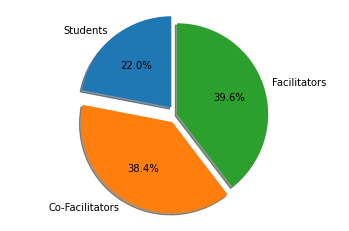

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
labels = 'Students', 'Co-Facilitators', 'Facilitators'
values = [students_count, co_facilitators_count, facilitators_count]
explode = (0.1, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Download Raw Unbalanced Dataset

In [108]:
from IPython.display import display, FileLink

local_file = FileLink(f'{output_to}', result_html_prefix="Click here to download: ")
display(local_file)

C:\Users\alexi\PycharmProjects\AolmeScripts\output\unbalanced_20201008010117.csv

## Prepare Balanced Dataset

The target of this module is creating a balanced dataset from the files, to allow the Deep Learning models to equally learn for each role:

In [109]:
sub_students = df.loc[df['Role'] == 'Student']
sub_co_facilitators = df.loc[df['Role'] == 'Co-Facilitator']
sub_facilitators = df.loc[df['Role'] == 'Facilitator']

if students_count < co_facilitators_count and students_count < facilitators_count:
    sub_co_facilitators = sub_co_facilitators.head(students_count)
    sub_facilitators = sub_facilitators.head(students_count)
elif co_facilitators_count < students_count and co_facilitators_count < facilitators_count:
    sub_students = sub_students.head(co_facilitators_count)
    sub_facilitators = sub_facilitators.head(co_facilitators_count)
else:
    sub_students = sub_students.head(facilitators_count)
    sub_co_facilitators = sub_co_facilitators.head(facilitators_count)

balanced_df = DataFrame(sub_students, columns=['Role', 'Text'])
balanced_df = balanced_df.append(sub_co_facilitators)
balanced_df = balanced_df.append(sub_facilitators)

students_count = len(balanced_df[balanced_df['Role'] == 'Student'])
facilitators_count = len(balanced_df[balanced_df['Role'] == 'Facilitator'])
co_facilitators_count = len(balanced_df[balanced_df['Role'] == 'Co-Facilitator'])

total = students_count + facilitators_count + co_facilitators_count

print(f'Students Count: {students_count} ({students_count * 100 / total:.2f}%)')
print(f'Facilitators Count: {facilitators_count} ({facilitators_count * 100 / total:.2f}%)')
print(f'CoFacilitators Count: {co_facilitators_count} ({co_facilitators_count * 100 / total:.2f}%)')
print(f'Total Rows: {total}')

output_to = f'output/balanced_{d1}.csv'

balanced_df.to_csv(output_to, index=False)

output_filename = f'The CSV file has been created at {output_to}'
print('\n' + '#' * len(output_filename))
print(output_filename)

Students Count: 127 (33.33%)
Facilitators Count: 127 (33.33%)
CoFacilitators Count: 127 (33.33%)
Total Rows: 381

###################################################################
The CSV file has been created at output/balanced_20201008010117.csv


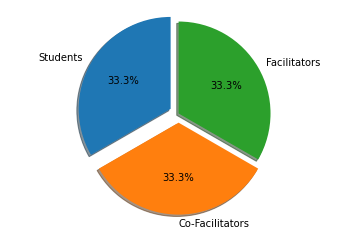

In [110]:
values = [students_count, co_facilitators_count, facilitators_count]
explode = (0.1, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Download Balanced Dataset

In [111]:
from IPython.display import display, FileLink

local_file = FileLink(f'{output_to}', result_html_prefix="Click here to download: ")
display(local_file)


C:\Users\alexi\PycharmProjects\AolmeScripts\output\balanced_20201008010117.csv